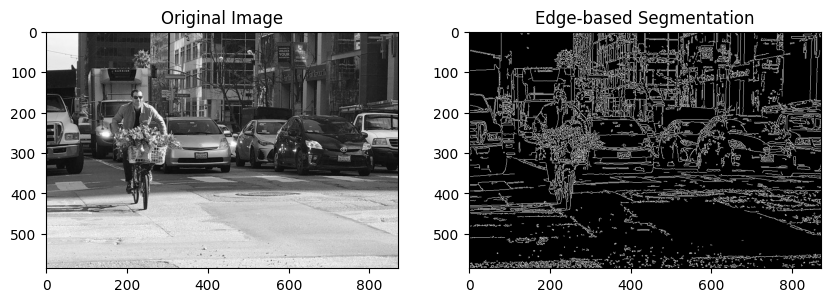

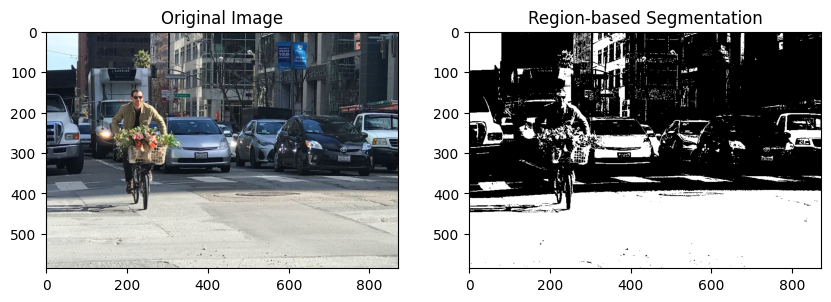

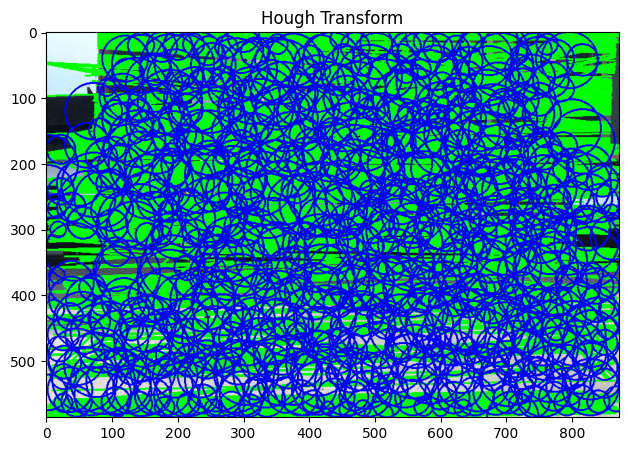

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Task 1: Image Segmentation and Object Identification using Hough Transform

# T1.1 Edge-based segmentation
def edge_based_segmentation(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 100, 200)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')

    plt.subplot(1,2,2)
    plt.title("Edge-based Segmentation")
    plt.imshow(edges, cmap='gray')
    plt.show()

    return edges

# T1.2 Region-based segmentation
def region_based_segmentation(image_path):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(image_gray, 127, 255, cv2.THRESH_BINARY)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.subplot(1,2,2)
    plt.title("Region-based Segmentation")
    plt.imshow(threshold, cmap='gray')
    plt.show()

# T1.3 Hough Transform for detecting specific shapes
def hough_transform(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    # Detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 68, minLineLength=15, maxLineGap=250)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Detect circles
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=5, maxRadius=50)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(image, (i[0], i[1]), i[2], (255, 0, 0), 2)

    plt.figure(figsize=(10,5))
    plt.title("Hough Transform")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()


image_path = "road.jpg"
edges = edge_based_segmentation(image_path)
region_based_segmentation(image_path)
hough_transform(image_path)


 YOLO Object Detection


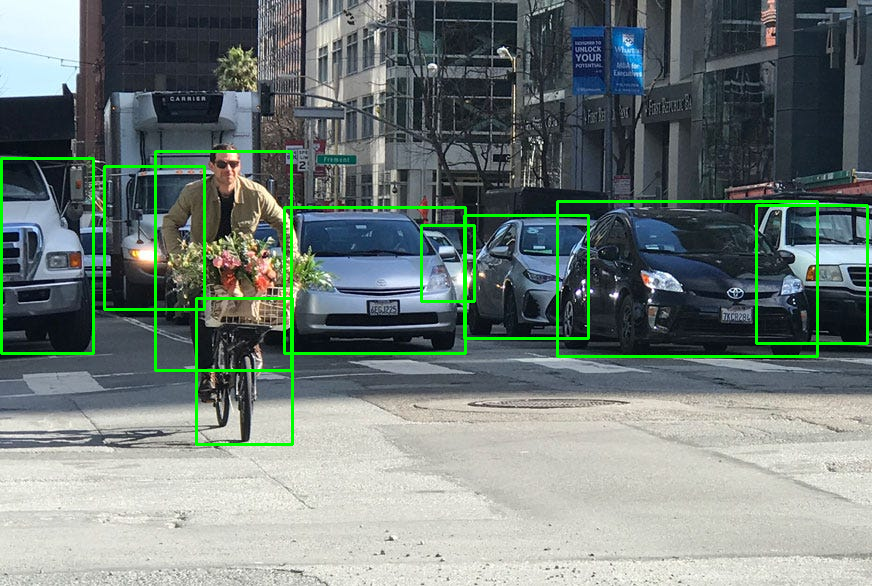

Faster R-CNN Object Detection


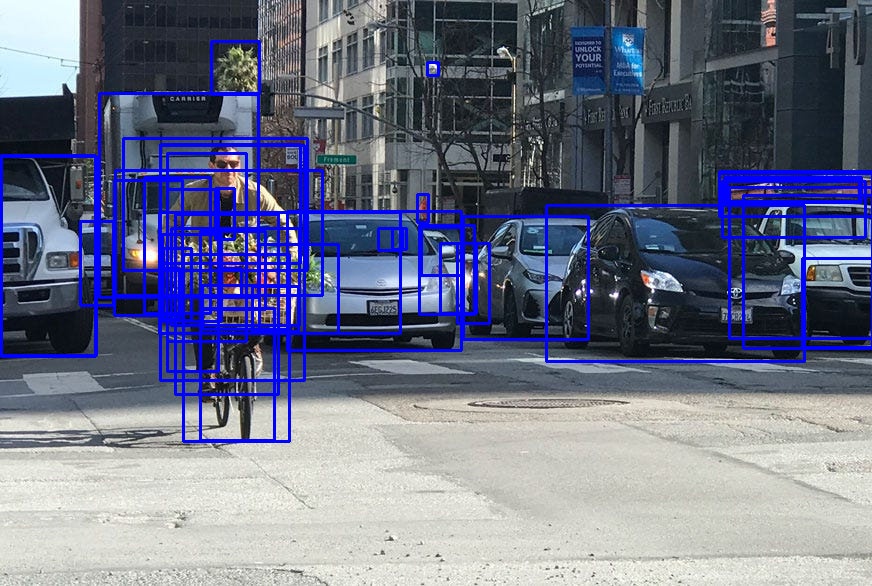

In [9]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from google.colab.patches import cv2_imshow
import warnings
warnings.filterwarnings("ignore")

# Download YOLO model files
#!wget -O yolov3.weights https://pjreddie.com/media/files/yolov3.weights                        (uncomment if you dont have yolo files)
#!wget -O yolov3.cfg https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true     (uncomment if you dont have yolo files)

# Load an image
image_path = 'road.jpg'  # Replace with your image path
image = cv2.imread(image_path)

# Task 1.1: YOLO Object Detection
def detect_objects_yolo(image):
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)

    boxes, confidences, class_ids = [], [], []
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype("int")
                x, y = int(center_x - w / 2), int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    for i in indices:
        x, y, w, h = boxes[i]
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    print(" YOLO Object Detection")
    cv2_imshow(image)

detect_objects_yolo(image.copy())

# Task 1.2: Faster R-CNN Object Detection
def detect_objects_rcnn(image):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    transform = transforms.Compose([transforms.ToTensor()])
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(img_tensor)

    for box in outputs[0]['boxes']:  # Bounding boxes
        x1, y1, x2, y2 = map(int, box.tolist())
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    print("Faster R-CNN Object Detection")
    cv2_imshow(image)

detect_objects_rcnn(image.copy())